In [2]:
import netket as nk
from netket.utils import HashableArray
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import pickle
from netket.callbacks import InvalidLossStopping
# import the ViT model
import sys
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/models')
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/Logger_Pickle')

from json_log import PickledJsonLog
# from ViT_2d_Vers2_Checkpoint import *
from vmc_2spins_sampler import *
from Afm_Model_functions import *
# from ViTmodel_2d_Vers2 import * 
import ViT_2d_Vers3_XavierUniform as vitX

from convergence_stopping import LateConvergenceStopping
# import the sampler choosing between minSR and regular SR
from optax.schedules import cosine_decay_schedule, linear_schedule



# In here we find a good set of paramters in order to start then the initialization of the Vision transformer


good params mean if we sample some spin configurations we want to get only states with low magnetizatioin!

It is for the case of nl2 d24 with patching xy_12

In [4]:
L = 6

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)


pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,8,9,10,11]
}

Ha16, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = None, make_rotation=False, exchange_XY=False)

XX = Exchange_OP(hi2d, TriGraph).to_jax_operator()

sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
# sa_2flip = nk.sampler.MetropolisSampler(hilbert=hi2d, rule=TwoLocalRule(), n_chains=32, sweep_size=3*hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)


rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])
rules3070 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.3, 0.7])
rules7030 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.7, 0.3])

sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=32, sweep_size=3*hi2d.size)
sa_HaEx3070 = nk.sampler.MetropolisSampler(hi2d, rules3070, n_chains=32, sweep_size=3*hi2d.size)
sa_HaEx7030 = nk.sampler.MetropolisSampler(hi2d, rules7030, n_chains=32, sweep_size=3*hi2d.size)


In [ ]:
pVit = {
    'd': 24,
    'h': 6,
    'nl': 2,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 1,
    'Cy': 2,
    'patch_arr': HashableArray(np.arange(0, L**2).reshape((-1,2))),
}

m_Vit = vitX.ViT_2d(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'])



In [150]:
start_configs = hi2d.random_state(jax.random.PRNGKey(4), 2**10)
p_init = m_Vit.init(jax.random.PRNGKey(16), start_configs)

In [151]:
vs_vit = nk.vqs.MCState(sampler=sa_HaEx5050, model = m_Vit, n_samples=2**12, chunk_size=2**12, n_discard_per_chain=16)

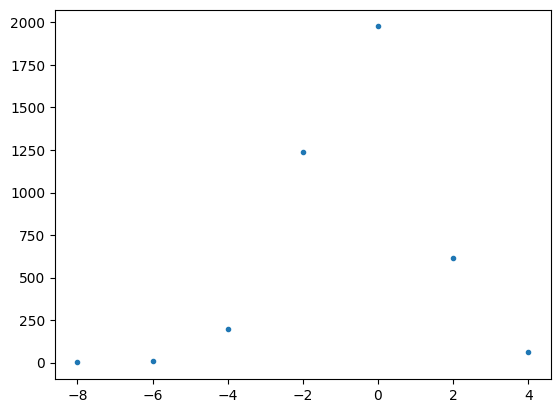

In [152]:
vs_vit.variables = p_init

x,y = jnp.unique(jnp.sum(vs_vit.samples.reshape(-1, L**2), axis=-1)/2, return_counts=True)

plt.plot(x,y, '.')

In [153]:
with open('good_init_params5050.pickle', 'wb') as f:
    pickle.dump(p_init, f)

In [169]:
start_configs = hi2d.random_state(jax.random.PRNGKey(4), 2**10)
p_init = m_Vit.init(jax.random.PRNGKey(16), start_configs)   # 0 works ok-ish

In [170]:
vs_vit = nk.vqs.MCState(sampler=sa_HaEx7030, model = m_Vit, n_samples=2**12, chunk_size=2**12, n_discard_per_chain=16)
vs_vit.variables = p_init

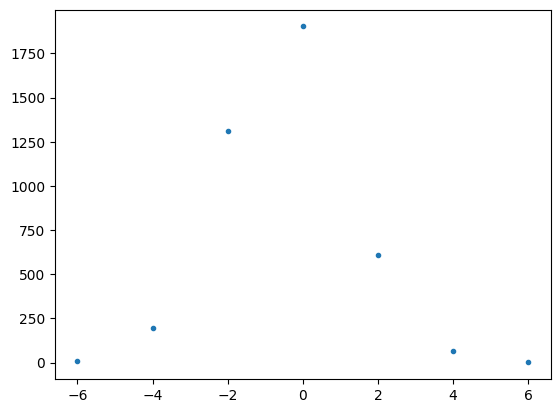

In [171]:
vs_vit.variables = p_init

x,y = jnp.unique(jnp.sum(vs_vit.samples.reshape(-1, L**2), axis=-1)/2, return_counts=True)

plt.plot(x,y, '.')

In [172]:
with open('good_init_params7030.pickle', 'wb') as f:
    pickle.dump(p_init, f)

In [173]:
with open('good_init_params5050.pickle', 'rb') as f:
    p_init_test = pickle.load(f)

In [174]:
vs_vit.variables = p_init_test

In [205]:
start_configs = hi2d.random_state(jax.random.PRNGKey(4), 2**10)
p_init = m_Vit.init(jax.random.PRNGKey(16), start_configs)

In [206]:
vs_vit = nk.vqs.MCState(sampler=sa_HaEx3070, model = m_Vit, n_samples=2**12, chunk_size=2**12, n_discard_per_chain=16)
vs_vit.variables = p_init

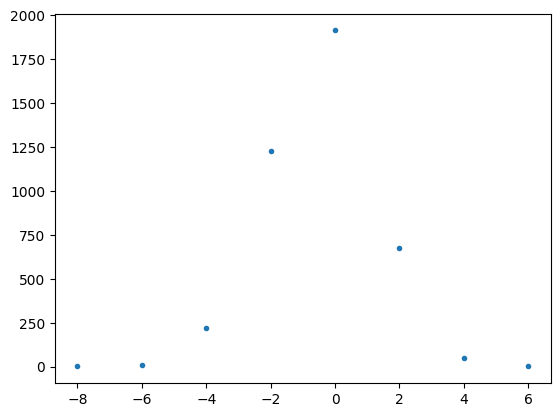

In [207]:
vs_vit.variables = p_init

x,y = jnp.unique(jnp.sum(vs_vit.samples.reshape(-1, L**2), axis=-1)/2, return_counts=True)

plt.plot(x,y, '.')

In [208]:
with open('good_init_params3070.pickle', 'wb') as f:
    pickle.dump(p_init, f)